# 線形回帰

## 仮説・モデル表現

- 我々は「モデル」と言う表現に親しみがあるが、界隈では昔ながらの風習で"hypothesis"などと呼ぶらしい。とはいえ日本語の「仮説」としての意味合いは特に無いっぽい
- $h_\theta$と言う関数により入力データ$x$を出力データ$y$と対応関係を作ろうとする試み
  - $h_\theta$は「パラメータ$\theta$を持つ仮説」という意味
- ここでは以下のモデルを用いて単一の出力値を予測しようとする

$$ \hat{y} = h_{\theta}(x) = \theta_0 + \theta_{1}x $$

予測に用いるデータは以下。

| input | output |
|-------|--------|
| 0     | 3      |
| 1     | 4      |
| 2     | 7      |
| 3     | 8      |

上記のデータセットに近い出力が得られるモデルのパラメータを$\theta_0=2, \theta_1=2$と仮定する。つまり $h_\theta(x)=2+2x$とすると

In [1]:
def h(x):
    return 2 + 2*x

for x in range(4):
    print("x:%s f(x):%d" % (x, h(x)))

x:0 f(x):2
x:1 f(x):4
x:2 f(x):6
x:3 f(x):8


先程のデータセットと出力結果を比較したのが以下の表、当たらずとも遠からずと言ったところ。果たしてこのモデルの精度についてどのように議論するべきなのだろうか？

| input | output | predict |
|-------|--------|---------|
| 0     | 3      | 2       |
| 1     | 4      | 4       |
| 2     | 7      | 6       |
| 3     | 8      | 8       |

## 課題1. 行列式を用いてモデル表現を実装してください。
### ※YOUR CODE IS HERE

In [2]:
import numpy as np

X = np.array([[0], [1], [2], [3]])

m, n = X.shape

X_ = np.c_[np.ones(m), X]

assert X_.shape == (4, 2) # m:4, n:2

theta = np.array([[2], [2]])

def h(X, theta):
    return np.dot(X, theta)

np.testing.assert_allclose(h(X_, theta), np.array([[2], [4], [6], [8]]))

## コスト関数

モデル精度を測るために「コスト関数」と言う概念を導入する。このコスト関数は実際の出力$y$と$h_\theta(x)$から得られた予測値$\hat{y}$の差分の総和を平均したものとする。（実際には1/2が乗じられているが）

$$J(\theta_0, \theta_1)=\frac{1}{2m}\sum_{i=1}^{m}(\hat{y} - y_i)^2 = \frac{1}{2m}\sum_{i=1}^{m}(h_\theta(x_i) - y_i)^2$$

これが俗に言う「平均二乗誤差」。なぜ$\frac{1}{2m}$かというと、あらゆる解説の中で幾度も語られていると思うが、後述する勾配降下法の計算の際に二乗関数の微分項が$\frac{1}{2}$で上手く打ち消すことができるから。

このコスト関数を最小化するモデルを追い求めていくのが回帰のタスクになる。

平均二乗誤差を視覚化すると以下になる。ここでは青/赤のラインがoutputとpredictの乖離を表現している。我々がモデルを作る際には各出力点から予測点までの距離の和が最小化するような$\theta$（理想的には$J(\theta_0, \theta_1)=0$）を選択することが求められる。

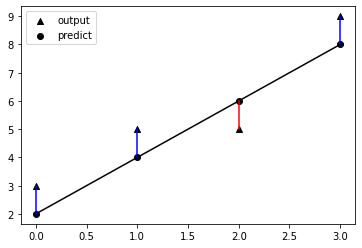

In [3]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.DataFrame(
    {'input':[0, 1, 2, 3], 
     'output':[3, 5, 5, 9], 
     'predict':[2, 4, 6, 8]})

fig = plt.figure()
plt.scatter(df['input'], df['output'], color='black', label='output', marker='^')
plt.scatter(df['input'], df['predict'], color='black', label='predict')
plt.plot(df['input'], df['predict'], color='black')
for i in range(4):
    y0 = df['predict'][i]
    y1 = df['output'][i]
    if (y1 - y0) > 0:
        color = 'blue'
    else:
        color = 'red'
    plt.plot([i, i], [y0, y1], color=color)
plt.legend()

## 課題2. 行列式を用いてコスト関数を実装してください。
### ※YOUR CODE IS HERE

In [4]:
def costFunction(X, y, theta):
    """calculate cost function
    
    Args:
        - X(np.array): Input values
        - y(np.array): Actual output values
        - theta(np.array): parameters of hypothesis
    
    Returns:
        - J(float):
    """
    m = len(X)
    h = np.dot(X, theta)
    J = 1/(2*m) * np.sum((h - y)**2)
    return J

In [ ]:
X = np.array([[1, 2], [1, 3], [1, 4], [1, 5]])
y = np.array([7, 6, 5, 4])
theta = np.array([0.1, 0.2])
np.testing.assert_allclose(costFunction(X, y, theta), 11.945, rtol=1e-05)

X = np.array([[1, 2, 3], [1, 3, 4], [1, 4, 5], [1, 5, 6]])
y = np.array([[7], [6], [5], [4]])
theta = np.array([[0.1], [0.2], [0.3]])
np.testing.assert_allclose(costFunction(X, y, theta), 7.0175, rtol=1e-05)

X = np.array([[2, 1, 3], [7, 1, 9], [1, 8, 1], [3, 7, 4]])
y = np.array([[2], [5], [5], [6]])
theta = np.array([[0.4], [0.6], [0.8]])
np.testing.assert_allclose(costFunction(X, y, theta), 5.295, rtol=1e-05)

## 勾配降下法

すでに我々は手元のデータセットからその背後に隠れる数学的なモデルを探し出す理論を身に付けたわけだが、何か足りない気がする。その違和感とは「$J(\theta_0, \theta_1)=0$となるまたはそれに近い$\theta$はそう簡単に見つかるのか？」だろう。

想像してみて欲しい、仮に10000点のデータセットに対してコスト関数が最小になる$\theta$を探す作業を。

そこで登場するのが「最適化」、とはいえ大して難解なものではない。今回は最適解を解析的に解くことはせずあくまでも数値計算のみで解を近似的に求めていく。その際に有効なツールとなるのが「勾配降下法」だ。

![gradient-descend-3d](img/gradient-descend-3d.png)

これは$x$と$y$とではなくモデルのパラメータ$\theta$とそれを用いて計算したコスト関数のプロットである。このケースでは、仮に$\theta_0=\theta_1=0$からスタートしたならば直感的にどの方向にパラメーターを探索していけば良いかがわかるはずだ。これを数学的にどのように実装すれば良いのだろうか？

ここで「微分」の概念を取り入れる。具体的にはこのコスト関数の接線を降下方向に一定間隔でずらしていきその接線の傾きが0、またはそれに近しくなる点を探索していく。この時の接線をずらす間隔を「学習率」（しばしば$\alpha$と表現する）と呼ばれる。

上述の手順は以下の式の繰り返しで表すことができる。このとき$j$は特徴量のインデックス番号を表す。

$$ \theta_j := \theta_j - \alpha\frac{\partial}{\partial\theta_j}J(\theta_0, \theta_1) \ \ j\in {0, 1} $$

実際に線形回帰の問題に適用する際には以下のように若干の式変形を行う必要がある。

$$\theta_0 := \theta_0 - \alpha\frac{1}{m}\sum_{i=1}^{m}(h_{\theta}(x_i) - y_i){{x_i}_0}$$

$$\theta_1 := \theta_1 - \alpha\frac{1}{m}\sum_{i=1}^{m}(h_{\theta}(x_i) - y_i){{x_i}_1}$$

※本講習のように定数項が常に1であるとするならば$\theta_0$の更新式は以下のようにも表現できる
$$\theta_0 := \theta_0 - \alpha\frac{1}{m}\sum_{i=1}^{m}(h_{\theta}(x_i) - y_i)$$

上式の導出は以下の通り。

$\frac {\partial J(\theta)}{\partial \theta_j} = \frac {\partial }{\partial \theta_j} \frac{1}{2} (h_\theta (x) - y)^2$  
$\qquad = 2 \cdot \frac{1}{2} (h_\theta(x) - y) \cdot \frac {\partial }{\partial \theta_j} (h_\theta(x) - y)$  
$\qquad = (h_\theta(x) - y) \cdot \frac {\partial }{\partial \theta_j} \left ( \sum_{i=0}^n \theta_i x_i - y_i \right )$  
$\qquad = (h_\theta(x) - y)x_j$

## 実装のためのヒント

まず初めに先ほどの更新式における以下の項はそれぞれスカラーであることに注意する。
$$(h_\theta(x_i) - y_i){{x_i}_0}$$
$$(h_\theta(x_i) - y_i){{x_i}_1}$$
このとき、たとえば$\theta_0$の更新式第二項目は以下と同等であると言える。

$$ (h_\theta(x_0) - y_0){{x_0}_0} + (h_\theta(x_1) - y_1){{x_1}_0} + \cdots + (h_\theta(x_m) - y_m){{x_m}_0}  $$

これをさらに簡素な表現にすると以下のようなベクトルの内積として表現できる。

$$ a_0b_0 + a_1b_1 + \cdots + a_nb_n = \vec{a} \cdot \vec{b} \\ \vec{a}: \vec{(h_\theta(x_i) - y_i)}, \ \ \vec{b}: \vec{{x_i}_0}, \ 0\leq i \leq m$$
よって先ほどの更新式の第二項についてはXと(h-y)の内積を求めてやれば良いことになる。ただし二つの行列の形が内積可能であることが必要なので適宜転置などで変形しなければならない。

## 勾配とは？

そもそもの勾配の定義から振り返ろう。以下のような関数fについて考える。

$$f(x) = 3x_1^2 - 2x_1x_2 + 3x_2^2 -4x_1 -4x_2$$

![fig1](img/fig1.gif)

このときベクトル$\nabla f(x)$を点xにおける関数fの勾配(gradient)という。

$$ \nabla f(x) = \left( \frac{\partial f(x)}{\partial x_1}, \frac{\partial f(x)}{\partial x_2}, \cdots, \frac{\partial f(x)}{\partial x_n} \right) \in \mathbb R^n $$

※ただし以下が成り立つ場合（これは2点を結ぶ線分の傾きから求められますよね？）

$$ f(x+d) = f(x) + \nabla f(x)^Td + o(\Vert{d}\Vert), d \in \mathbb R^n$$

この定義に基づくと上式の勾配は以下で表すことができる。

$$\nabla f(x) = \begin{pmatrix}
6x_1-2x_2-4 \\
-2x_1 + 6x2 -4 \\
\end{pmatrix}
$$

ここで勾配の定義をより直感的にするために以下の2点における勾配を考えてみる。

$$a = (0, 0)^T, \nabla f(a) = (-4, -4)^T$$
$$b = (2, 0)^T, \nabla f(b) = (8, -8)^T$$

![fig2](img/fig2.jpg)

このようにfにおける各点の勾配は接線に対して垂直なベクトルとして表される。
そして上図の各点において傾きが最大となる方向を表し、勾配と反対になる方向が降下方向となる。

つまり探索方向を勾配$\nabla f(x)$の逆（降下）方向に定めて探索することから「勾配降下法」と言われる所以である（と思う。）

![fig3](img/fig3.png)

## 表記と用語

- $A_{ij}$はi行j列の行列$A$を指す
- n行のベクトルはn次元ベクトルを指す
- $v_i$はベクトルのi番目の要素を指す
- ベクトルや行列は0番目から始まる
- 行列は大文字、ベクトルは小文字で表す
- 「スカラー」は単一の値を示し「ベクトル」ではない
- $\mathbb{R}$は実数スカラーの集合
- $\mathbb{R}^n$は実数のn次元ベクトル集合

## 行列の演算、式とコードの対応

$\sum_{i=1}^{n}x_iy_i = \boldsymbol{x}^T\boldsymbol{y}$ : ```np.dot(x, y)```

$\sum_{i=1}^{n}x_i^2$ : ```(x**2).sum()```

$\frac{1}{n}(\sum_{i=1}^{n} x_i )^2$ : ```x.sum()**2/n```

## 課題3. 勾配降下法を実装してください。
### ※YOUR CODE IS HERE

In [ ]:
def gradientDescent(X, y, theta, alpha, iterations):
    """calculate gradient descent
    
    Args:
        - X(np.array): Input values
        - y(np.array): Actual output values
        - theta(np.array): parameters of hypothesis
        - alpha(float): learning rate
        - iterations(int): number of iterations
    
    Returns:
        - theta_min(np.array): parameters of hypothesis which make minimize cost function 
        - j_hist(list): history of cost "j"
    """
    m, n = X.shape
    j_history = []
    for i in range(iterations):
        h = np.dot(X, theta)
        theta_0 = theta[0] - alpha * (1/m) * np.dot(X[:, 0].T, (h - y))
#         theta_0 = theta[0] - alpha * (1/m) * np.sum(h - y) # equivalent to above one
        theta_1 = theta[1] - alpha * (1/m) * np.dot(X[:, 1].T, (h - y))
        theta = np.c_[theta_0, theta_1].reshape(-1, 1)
        j_history.append(costFunction(X, y, theta))
    return theta_min, j_hist

In [5]:
X = np.array([[1, 5], [1, 2], [1, 4], [1, 5]])
y = np.array([[1], [6], [4], [2]])
theta = np.array([[0], [0]])
alpha = 0.01
iterations = 1000
theta_min, j_hist = gradientDescent(X, y, theta, alpha, iterations)
np.testing.assert_allclose(theta_min, np.array([[ 5.21475495], [-0.57334591]]), rtol=1e-07)

X = np.array([[1, 5], [1, 2]])
y = np.array([[1], [6]])
theta = np.array([[0.5], [0.5]])
alpha = 0.1
iterations = 10

theta_min, j_hist = gradientDescent(X, y, theta, alpha, iterations)
np.testing.assert_allclose(theta_min, np.array([[1.70986322], [0.19229354]]), rtol=1e-07)
theta_min, j_hist = gradientDescent(X, y, theta, alpha, iterations)
np.testing.assert_allclose(j_hist, 
                        np.array([5.8853125, 5.7138519, 5.5475438, 5.3861213, 5.2294088, 5.0772597, 4.9295383, 4.7861152, 4.6468651, 4.5116663]),
                        rtol=1e-07)


# 多変数への拡張

以下の表記を導入することで複数の入力変数を取り扱えるようにする。

$x_j^{(i)}$ = $j$個の特徴量を持つ$i$番目の訓練データ  
$x^{(i)}$ = $i$番目の訓練データで全ての特徴量を含む列ベクトル  
$m$ = 訓練データの数  
$n$ = len($x^{(i)}$)、特徴量の数

それでは多変数のモデルを以下のように定義する

$$h_\theta(x) = \theta_0x_0 + \theta_1x_1+\theta_2x_2+ \theta_3x_3+\cdots+\theta_nx_n$$

上式に対する直感的な理解を育むところから始める。たとえば$\theta_0$は家のベース価格と考えることができる。$\theta_1$は土地の広さが価格に与える係数で$x_1$は実際の広さ、$\theta_2$はベッドルームの数が価格に与える係数で$x_2$は実際のベッドルームの数、といった具合に考えてみてはどうだろうか。

実装の際には行列の演算規則に従って上記のモデルを以下のように表現したものを考慮する必要がある。

$$h_\theta(x) = [\theta_0 \quad \theta_1 \quad \theta_2 \quad \cdots \quad \theta_n] \begin{bmatrix} x_0  \\ x_1 \\ x_2 \\ \vdots \\ x_n \end{bmatrix} = \theta^Tx$$

これはいわゆる「ベクトル化」と呼ばれるものです。ちなみに本講習では理解を容易なものにするため$x_0^{(i)} = 1 \ for \ (i  \in 1, \ \ldots, m)$、つまり全ての切片項は1とみなします。（実際にそれが最善の値でないことはお分かりかと思いますが）。そしてこの$x_0^{(i)} = 1$をxに追加することでthetaとxの演算ができるようになります。この時それぞれの要素数は$n+1$と同じになります。

たとえば訓練データは以下のようになります。以降$X$はデータ$x_{(i)}$（𝑖 番目の訓練データで全ての特徴量を含む列ベクトル）を行ごとに保持する行列を表すものとします。

$$ X = \begin {bmatrix} x_0^{(1)}&x_1^{(1)} \\ x_0^{(2)}&x_1^{(2)} \\ x_0^{(3)}&x_1^{(3)} \end {bmatrix}, \theta=\begin{bmatrix} \theta_0 \\ \theta_1 \end {bmatrix}$$

## コスト関数（多変数）

パラメーターベクトル$\theta$のコスト関数は以下となる。

$$J(\theta) = \frac{1}{2m}\sum_{i=1}^{m}(h_{\theta}(x^{(i)}) - y^{(i)}) ^ 2$$

単変数のものと異なり$x,y$の表現が多変数の導入に合わせて変わっていることを確認してほしい。

## 多変数の勾配降下法

こちらは単変数のそれと同じ表現が可能で、違いは**n個の特徴量に対して**計算が収束するまで以下の計算を繰り返すところになる。

$$\theta_0 := \theta_0 - \alpha \frac{1}{m} \sum_{i=1}^{m} (h_\theta(x^{(i)}) - y^{(i)}) \cdot x_0^{(i)}$$

$$\theta_1 := \theta_1 - \alpha \frac{1}{m} \sum_{i=1}^{m} (h_\theta(x^{(i)}) - y^{(i)}) \cdot x_1^{(i)}$$

$$\theta_2 := \theta_2 - \alpha \frac{1}{m} \sum_{i=1}^{m} (h_\theta(x^{(i)}) - y^{(i)}) \cdot x_2^{(i)}$$

$$\vdots$$

上式を一般化すると以下となる。右辺の最終項を列ベクトルに置換したものになる。

$$\theta_j := \theta_j - \alpha \frac{1}{m} \sum_{i=1}^{m} (h_\theta(x^{(i)}) - y^{(i)}) \cdot x_j^{(i)} \qquad for \quad j := 0...n $$

## 行列表記への変換

勾配降下法を以下のように表現する

$$\theta := \theta - \alpha \nabla J(\theta)$$

$\nabla J(\theta)$は以下の形式で表される列ベクトルとなる。

$$\nabla J(\theta) = \begin {bmatrix} \frac{\partial J(\theta)}{\partial \theta_0} \frac{\partial J(\theta)}{\partial \theta_1} \cdots \frac{\partial J(\theta)}{\partial \theta_n} \end {bmatrix}$$

この$j$番目の微分項は以下２通りの内積の和として表現可能である。

$$\frac {\partial J(\theta)}{\partial \theta_j} = \frac{1}{m} \sum_{i=1}^{m}(h_\theta(x^{(i)})-y^{(i)}) \cdot x_j^{(i)} \\ \qquad = \frac{1}{m} \sum_{i=1}^{m} x_j^{(i)}  \cdot (h_\theta(x^{(i)}) - y^{(i)})$$

ここで$x_j^{(i)}$for i=1,...,mはj番目の列のm個の要素を表しており$\overset {\rightarrow}{x_{j}} $と等価である。

さらに別の項$(h_\theta(x^{(i)}) - y{(i)})$は予測値$h_\theta(x^{(i)})$と真値$y^{(i)}$の偏差ベクトルとなる。以上を踏まえると上式は以下のように表現できる。

$$\frac{\partial J(\theta)}{\partial \theta_j} = \frac{1}{m} \overset {\rightarrow T}{x_j}(X\theta - \overset{\rightarrow}{y})$$

最終的に勾配降下法は以下の行列式を更新していけば良いことになる。

$$\theta := \theta - \frac{\alpha}{m} X^T(X\theta - \overset {\rightarrow}y)$$

## 課題4. 勾配降下法を多変数に対応できるよう拡張してください。
### ※YOUR CODE IS HERE

In [ ]:
def gradientDescent_multi(X, y, theta, alpha, iterations):
    """calculate gradient descent for multi variables
    
    Args:
        - X(np.array): Input values
        - y(np.array): Actual output values
        - theta(np.array): parameters of hypothesis
        - alpha(float): learning rate
        - iterations(int): number of iterations
    
    Returns:
        - theta_min(np.array): parameters of hypothesis which make minimize cost function 
        - j_hist(list): history of cost "j"
    """
    return theta_min, j_hist

In [ ]:
X = np.array([[2, 1, 3], [7, 1, 9], [1, 8, 1], [3, 7, 4]])
y = np.array([[2], [5], [5], [6]])
theta = np.array([[0.1], [-0.2], [0.3]])

theta_min, j_hist = gradientDescent_multi(X, y, theta, 0.01, 10)
np.testing.assert_allclose(theta_min, np.array([[0.1855552 ], [0.50436048], [0.40137032]]), rtol=1e-06)

theta_min, j_hist = gradientDescent_multi(X, y, theta, 0.01, 10)
np.testing.assert_allclose(j_hist, 
                    np.array([3.6325468, 1.7660945, 1.0215168, 0.6410083, 0.4153055, 0.2722962, 0.1793844, 0.1184785, 0.0784287, 0.0520649]),
                    rtol=1e-06)

## 特徴量の正規化(Normalization or Scaling ?)

この効能は実際に体験してみないとわからない気がするが、一言で言うと「勾配降下法の収束のため」にこの手法を実施する。

それぞれの入力値をほぼ同じ範囲にすることで、勾配降下法を高速化することができます。これは、θが小さい範囲では早く下降し、大きい範囲ではゆっくりと下降するため、変数が非常に不均一な場合には、最適なところまで非効率的に振動してしまうからです。

![fig4](img/fig4.png)

![fig5](img/fig5.png)

これを防ぐには、入力変数の範囲を変更して、すべての変数がほぼ同じになるようにする必要があります。理想的には以下のいずれかのようになることが望ましい。

$$ -1 \leq x_{(i)} \leq 1$$ もしくは $$ -0.5 \leq x_{(i)} \leq 0.5$$

これらは厳密な要件ではなく、あくまでもスピードアップを図るためのものです。目標は、すべての入力変数を、多少の差はあれど、大体これらの範囲に収めることです。

そのための手法として、特徴量のスケーリングと平均値の正規化があります。

- 特徴量スケーリング: 入力値を入力変数の範囲（すなわち、最大値から最小値を引いたもの）で割ることで、新しい範囲が1になります。
- 平均正規化: 入力変数の値からその入力変数の平均値を引くことで、入力変数の新しい平均値が0になります。

これら2つの手法を実行するには、次の式のように入力値を調整する必要があります。

$$x_i := \frac{x_i - \mu_i}{s_i}$$

この時$\mu_i$は全ての特徴量（i）の平均値、$s_i$は（最大値-最小値)の範囲または標準偏差です。

範囲で割るのと、標準偏差で割るのとでは、結果が異なることに注意してください。本講習の課題では標準偏差を使います。

たとえば$x_i$は家の価格範囲が1000-20000、平均値が10000だとすると正規化は以下のように施される。

$$x_i := \frac{price - 1000}{1900}$$

## 課題5. 特徴量正規化を実装してください。
### ※YOUR CODE IS HERE

In [ ]:
def featureNormalize(X):
    """Normalize feature values
    
    Args:
        - X(np.array): feature values
        
    Returns:
        - X_norm(np.array): feature values normalized
    """
    return X_norm

In [ ]:
np.testing.assert_equal(featureNormalize(np.array([[1], [2], [3]])), np.array([[-1.], [0.], [1.]]))

## 本稿に入れられなかったトピック

- 多項式回帰
- 正規方程式